In [35]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import time
from scipy import misc
import imageio

0.21253633499145508 seconds


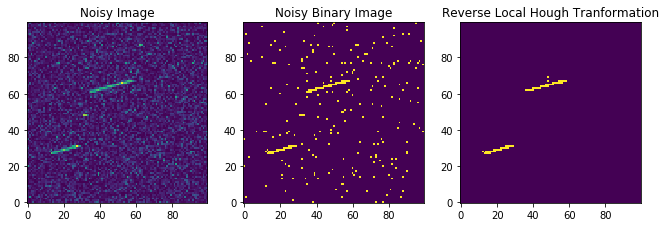

0.7987136840820312 seconds


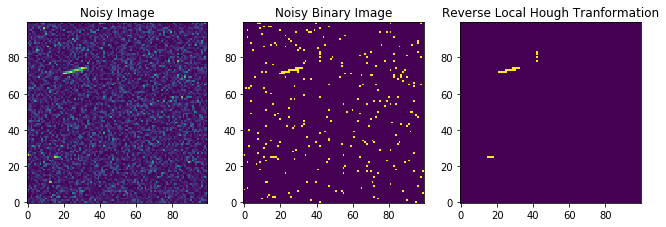

1.5855050086975098 seconds


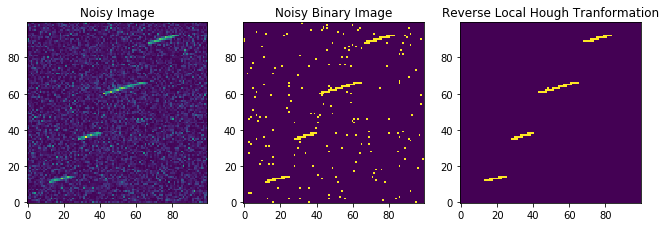

2.2183640003204346 seconds


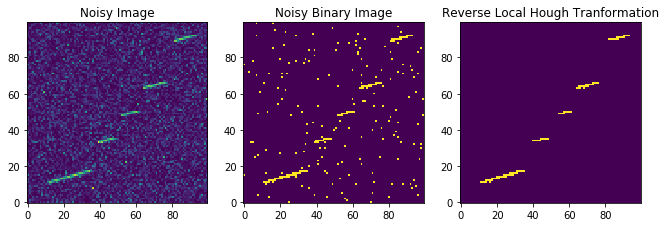

2.7510225772857666 seconds


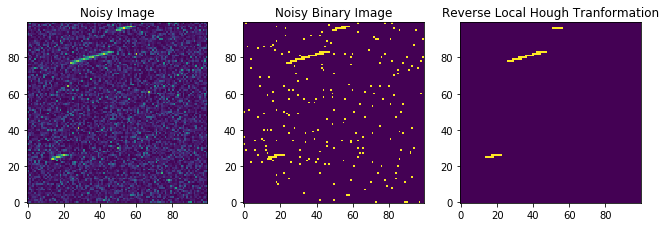

3.3900887966156006 seconds


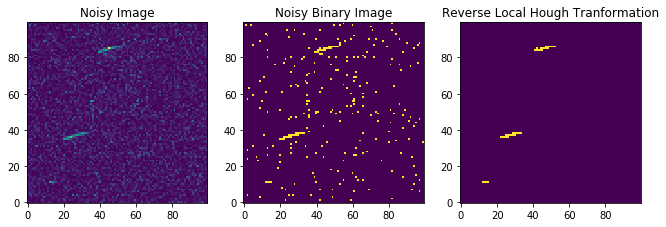

3.9229140281677246 seconds


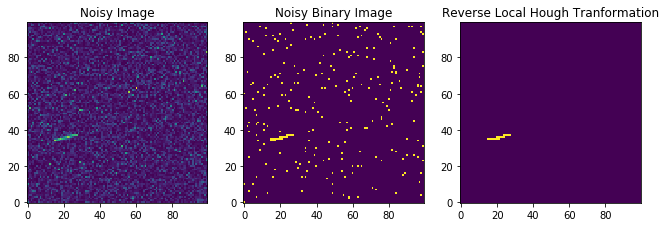

4.555769920349121 seconds


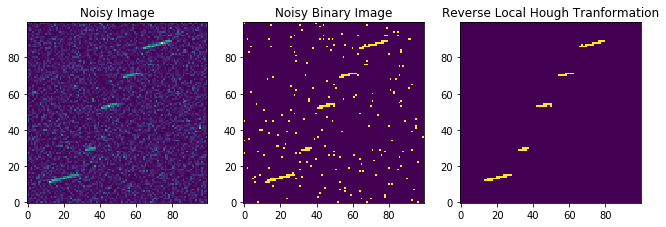

5.094921588897705 seconds


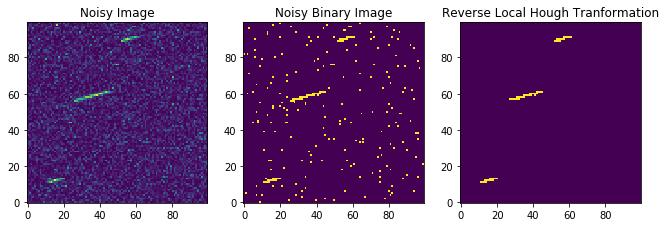

5.680914402008057 seconds


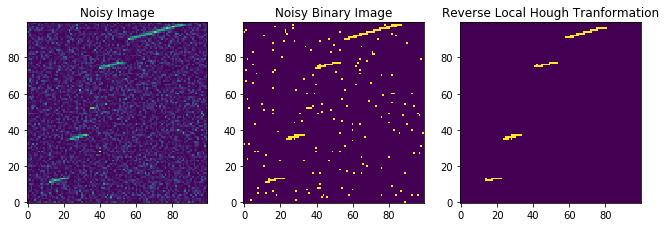

In [89]:
fig=10
accuracy_hist=[]
start=time.time()
for N in range(fig):

    pixel_threshold=3
    angle_dim=2
    window_size=7
    n_std=2.5

    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_100.png",)
    pixel=get_image(image,w0,t0,alpha)

    pixel_gray=get_gray(pixel)
    
    th_true=np.mean(pixel)+np.std(pixel)
    
    binary_gray=get_binary_gray(pixel_gray,th_true)
    
    img=get_pixel_new(pixel_gray)
    
    binary_img, binary_final = local_hough_track_reconstruction(img, window_size, angle_dim, pixel_threshold, n_std)

    end = time.time()
    print(end-start, "seconds")

    plt.figure(figsize=(11,11))
    plt.subplot(131), plt.imshow(img,origin='lower'),plt.title('Noisy Image')
    plt.subplot(132),plt.imshow(binary_img,origin='lower'),plt.title('Noisy Binary Image')
    plt.subplot(133),plt.imshow(binary_final,origin='lower'),plt.title('Reverse Local Hough Tranformation')
    plt.show()
    
   # accuracy=get_accuracy(binary_gray,binary_final)
   # accuracy_hist.append(accuracy)

#get_accuracy_hist(accuracy_hist,fig)

In [36]:
def get_image(image,w0,t0,angle):
    start=time.time()
    t_prev=t0
    freq_prev=w0
    
    while(True):
        scatter_time=math.floor(t_prev+np.random.exponential(mean_life))  #Scattering times follow an exponential distribution
       # scatter_time=random.randint(t_prev+mean_life,t_prev+3*mean_life) 
        scatter_freq=round(((scatter_time-t_prev)/tan(angle))+freq_prev)
        if((scatter_time>=t_max)or(scatter_freq>=freq_max)):
            break
            
        ybar=freq_prev
        xbar=t_prev
    
        for i in range(t_prev,scatter_time):
            for j in range(freq_prev,scatter_freq):
                intensity=SNR*exp(-((((j-ybar))*sin(alpha))-(((i-xbar))*cos(alpha)))**2/(2*(sigma)**2))
                image[j,i]=(intensity,intensity,0)
                
        t_prev=scatter_time+1
        freq_prev=int(scatter_freq+get_energy_loss())
        
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i,j][0]==image[i,j][1]==image[i,j][2]==1):
                image[i,j]=(0,0,0)
    end=time.time()
    #print("Time:get_image()",end-start)
    return image

In [37]:
def get_energy_loss():
    u=np.random.uniform(0,1)
    if(u<=0.48):
        gen_loss=np.random.normal(12.6,0.925)
    else:
        while(True):
            gen_loss=stats.cauchy.rvs(14.1,6.25)
            if(gen_loss>=14.1):break
    return(gen_loss)

In [38]:
def get_gray(pixel):
    start=time.time()
    pixel_gray=np.dot(pixel,[1,1,1])
    end=time.time()
   # print("Time:get_gray()",end-start)
    return pixel_gray

In [39]:
def get_binary_gray(pixel_gray,th_true):
    start=time.time()
    binary_gray=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(pixel_gray.shape[0]):
        for j in range(pixel_gray.shape[1]):
            binary_gray[i,j]=0 if (pixel_gray[i,j]<(th_true*np.max(pixel_gray))) else 1
    end=time.time()
   # print("Time:get_binary_gray",end-start)
    return binary_gray

In [40]:
def get_pixel_new(pixel_gray):
    start=time.time()
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    end=time.time()
   # print("Time:get_pixel_gray()",end-start)
    return pixel_new

In [41]:
def get_voting(img, xx, yy, window, angles):
    
    #plt.imshow(window)
    #plt.show()
    
    #m_x=ma.masked_array(xx, mask=np.invert(window))
    #m_y=ma.masked_array(yy, mask=np.invert(window))
    
    #result=m_x*np.cos(angles[:,None,None])+m_y*np.sin(angles[:,None,None])
    result=xx*np.cos(angles[:,None,None])+yy*np.sin(angles[:,None,None])

    voting_matrix = np.zeros(shape=result.shape, dtype=bool)
    
    #bool_mask = (~result.mask)&(np.abs(result)<0.5)
    bool_mask = window[None,:,:]&(np.abs(result)<0.5)
    #bool_mask = np.abs(result)<0.5

    voting_matrix[bool_mask]=1

    return voting_matrix

In [42]:
def get_local_result(binary_result, pixel_threshold):
    
    hist = np.sum(binary_result,axis=(1,2))
    #plt.plot(hist)
    #plt.show()
    result_angles = hist>pixel_threshold

    return np.any(binary_result[result_angles],axis=0)

In [43]:
def get_window_centers(binary_img, width):
    ind = np.argwhere(binary_img)
    ind_c=(ind[:,0]>=width)&(ind[:,0]<binary_img.shape[0]-width)&\
            (ind[:,1]>=width)&(ind[:,1]<binary_img.shape[1]-width)
    ind = ind[ind_c]
    return ind

In [44]:
def get_binary_img(img,n_std):
    threshold = np.mean(img)+n_std*np.std(img)
    binary_img = img>threshold
    return binary_img

In [45]:
def local_hough_track_reconstruction(img, window_size, angle_dim, pixel_threshold, n_std):

    width = int(window_size/2)

    binary_img = get_binary_img(img,n_std)
    binary_final = np.zeros(shape=binary_img.shape, dtype=bool)
    
    angles = np.linspace(0,np.pi/2,angle_dim)

    ind = get_window_centers(binary_img, width)
    
    x = np.arange(-width, width+1, 1)
    y = np.arange(-width, width+1, 1)
    xx, yy = np.meshgrid(x,y)

    for k in range(ind.shape[0]):

        i=ind[k,0]
        j=ind[k,1]

        x_min = i-width
        x_max = i+width+1
        y_min = j-width
        y_max = j+width+1
    
        window = binary_img[x_min:x_max,y_min:y_max]

       # start=time.time()
        binary_result = get_voting(binary_img, xx, yy, window, angles)
       # end=time.time()
       # print(end-start)
        #print(binary_result[0])
        #plt.imshow(binary_result[10].transpose())
        #plt.show()
        hist = np.sum(binary_result,axis=(1,2))
        #plt.plot(hist)
        #plt.show()
        result_angles = hist>pixel_threshold

        local_result = get_local_result(binary_result,pixel_threshold)

        binary_final[x_min:x_max,y_min:y_max] = binary_final[x_min:x_max,y_min:y_max]|local_result


    return binary_img, binary_final

In [72]:
def get_accuracy(binary_true,reverse_hough):
    accuracy=np.zeros(shape=(binary_true.shape[0],binary_true.shape[1]))
    for i in range(binary_true.shape[0]):
        for j in range(binary_true.shape[1]):
            if(binary_true[i,j]==reverse_hough[i,j]):
                accuracy[i,j]=1
    accuracy_percentage=np.sum(accuracy)/(binary_true.shape[0]*binary_true.shape[1])            
    
    return accuracy_percentage

In [77]:
def get_accuracy_hist(accuracy_hist,N):
    x=np.arange(1,N+1)
    plt.hist(accuracy_hist,N)
   # plt.plot(x,accuracy_hist)
    #plt.ylim([0.95,1.00])
    plt.xlabel('Accuracy')
    plt.ylabel('Cases') 
    plt.show()